# t-SNE en UMAP
Naast {ref}`PCA <target-pca>` bestaan er andere technieken voor dimensionaliteitsreductie die specifiek ontworpen zijn om _lokale structuur_ en _non-lineaire patronen_ te behouden. Er zijn tegenwoordig twee belangrijke alternatieven: **t-SNE** (_t-distributed Stochastic Neighbor Embedding_) en **UMAP** (_Uniform Manifold Approximation and Projection_)

## Beperkingen van PCA
- Lineaire projectie: Kan alleen lineaire relaties vastleggen
- Globale focus: Maximaliseert variantie, maar behoudt lokale structuur niet noodzakelijk
- Euclidische afstanden: Werkt minder goed bij bepaalde structuren

## t-SNE

### Intuïtie

t-SNE (_t-distributed Stochastic Neighbor Embedding_) bewaart **lokale nabijheden** door punten die dicht bij elkaar liggen in de hoge-dimensionale ruimte ook dicht bij elkaar te houden in de lage-dimensionale visualisatie.

Kernidee: Converteer afstanden naar waarschijnlijkheden

1. In de originele _hoge_ dimensies: Voor elk punt $\mathbf{x}_i$, bereken de waarschijnlijkheid dat het punt $\mathbf{x}_j$ als "buur" kiest:
   $$p_{j|i} = \frac{\exp(-\|\mathbf{x}_i - \mathbf{x}_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|\mathbf{x}_i - \mathbf{x}_k\|^2 / 2\sigma_i^2)}$$
   
   Dit is een Normaalverdeling: punten die dicht bij $\mathbf{x}_i$ liggen krijgen een hoge waarschijnlijkheid.

2. In de target lage dimensies: Definieer analoge waarschijnlijkheden $q_{ij}$ voor de lage-dimensionale punten $\mathbf{y}_i$, maar nu met een **t-distributie** (Student-t met 1 vrijheidsgraad):
   $$q_{ij} = \frac{(1 + \|\mathbf{y}_i - \mathbf{y}_j\|^2)^{-1}}{\sum_{k \neq l}(1 + \|\mathbf{y}_k - \mathbf{y}_l\|^2)^{-1}}$$
   
   De t-distributie heeft zwaardere staarten dan een Normaalverdeling, wat helpt om het _crowding problem_ op te lossen (in lage dimensies is er minder ruimte voor alle punten).

3. Optimalisatie: Vind $\mathbf{y}_i$ die de {ref}`Kullback-Leibler divergentie <target-kl-divergence>` tussen $P$ en $Q$ minimaliseert:
   $$\text{KL}(P\|Q) = \sum_{i,j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$
   
   Intuïtief: straf situaties waar $p_{ij}$ groot is (punten zijn buren in hoge dimensies) maar $q_{ij}$ klein is (ver uit elkaar in visualisatie).

### Voordelen
- Excellente clustering: Onthult natuurlijke clusters zeer duidelijk
- Lokale structuur: Behoudt de nabijheid van vergelijkbare punten
- Niet-lineair: Kan complexe manifold-structuren vastleggen

### Beperkingen
- Geen globale structuur: Afstanden tussen clusters zijn niet betekenisvol
- Computationeel zwaar: $O(n^2)$ complexiteit (maar algoritmes als Barnes-Hut reduceren dit)
- Niet-deterministisch: Resultaat hangt af van initialisatie en hyperparameters
- Geen nieuwe data: Geen directe transformatie voor nieuwe punten (wel approximaties)


## UMAP

### Intuïtie

UMAP (_Uniform Manifold Approximation and Projection_) is gebaseerd op de assumptie dat data op een lager-dimensionale _manifold_ ligt in de hoge-dimensionale ruimte. Het gebruikt ideeën uit Riemannse meetkunde en topologie.

Kernidee: Bouw een grafische representatie van de data

1. Lokale afstandsmetriek: UMAP veronderstelt dat de data lokaal Euclidisch is. Voor elk punt $\mathbf{x}_i$ schatten we de lokale metriek door de afstand tot de dichtstbijzijnde buur $\rho_i$:
   $$w(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\max(0, d(\mathbf{x}_i, \mathbf{x}_j) - \rho_i)}{\sigma_i}\right)$$
   
   waar $d(\mathbf{x}_i, \mathbf{x}_j)$ de afstand tussen punten is. Dit creëert een _fuzzy graph_ waar edges gewichten hebben tussen 0 en 1.

2. Fuzzy simplicial complex: Deze gewichten $w(\mathbf{x}_i, \mathbf{x}_j)$ definiëren een topologische structuur:
   - Punt $j$ behoort "gedeeltelijk" tot de buurt van punt $i$
   - Symmetrizeer: $w_{ij} = w(\mathbf{x}_i, \mathbf{x}_j) + w(\mathbf{x}_j, \mathbf{x}_i) - w(\mathbf{x}_i, \mathbf{x}_j) \cdot w(\mathbf{x}_j, \mathbf{x}_i)$

3. Optimalisatie: Vind lage-dimensionale representatie met analoge graaf $V$ die $W$ benadert via {ref}`cross-entropy <target-cross-entropy>`:
   $$\mathcal{L} = \sum_{i,j} w_{ij} \log \frac{w_{ij}}{v_{ij}} + (1-w_{ij})\log\frac{1-w_{ij}}{1-v_{ij}}$$
   
   Dit balanceert:
   - Aantrekking: Als $w_{ij}$ hoog is (buren), maak $v_{ij}$ ook hoog
   - Afstoting: Als $w_{ij}$ laag is (geen buren), maak $v_{ij}$ ook laag

Sleutelverschil met t-SNE: UMAP bewaart meer globale structuur door de manifold-assumptie en fuzzy topologie.

### Voordelen
- Sneller dan t-SNE: $O(n)$ in plaats van $O(n^2)$, schaalbaar naar miljoenen punten
- Globale + lokale structuur: Behoudt zowel clusters als hun onderlinge posities
- Generaliseerbaar: Kan nieuwe data transformeren zonder opnieuw trainen
- Flexibel: Werkt goed voor verschillende $n_{\text{components}}$ (niet alleen 2D)

### Beperkingen
- Hyperparameters: Gevoelig voor `n_neighbors` en `min_dist`
- Theoretische basis: Complexere wiskunde, minder intuïtief dan PCA
- Interpretatie: Afstanden in lage dimensies zijn niet direct Euclidisch

## PCA vs t-SNE vs UMAP

| Eigenschap | PCA | t-SNE | UMAP |
|-----------|-----|-------|------|
| **Lineair/Non-lineair** | Lineair | Non-lineair | Non-lineair |
| **Behoudt** | Globale variantie | Lokale structuur | Lokaal + globaal |
| **Snelheid** | Zeer snel | Traag ($O(n^2)$) | Snel ($O(n)$) |
| **Schaalbaarheid** | Uitstekend | Beperkt | Uitstekend |
| **Nieuwe data** | Direct | Nee (approximatie) | Ja |
| **Determinisme** | Ja | Nee | Nee |
| **Interpretatie** | Duidelijk (PC's) | Visueel | Visueel |
| **Output** | Embedding | Embedding | Embedding |
| **Beste voor** | Lineaire trends, preprocessing | Visualisatie, clusters | Algemeen, grote data |

### Vuistregels voor keuze
#### PCA
- Data is ongeveer lineair
- Je wil snelle, schaalbare dimensionaliteitsreductie
- Je wil interpreteerbare componenten
- Je moet nieuwe data kunnen transformeren

#### t-SNE
- Visualisatie is het hoofddoel
- Je wil duidelijke cluster-separatie
- Dataset is niet te groot (< 10,000 punten)
- Lokale structuur is belangrijker dan globale

#### UMAP
- Je wil zowel clusters als hun onderlinge relaties
- Dataset is groot (> 10,000 punten)
- Je moet nieuwe data kunnen transformeren
- Je wil verder werken met de embedding (niet alleen visualisatie)

## Praktische toepassing

We gebruiken dezelfde AG News dataset met BERT embeddings als in het PCA notebook, maar nu vergelijken we PCA, t-SNE en UMAP naast elkaar. Dit laat zien hoe verschillende technieken dezelfde hoog-dimensionale data (768D) anders visualiseren.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoModel, AutoTokenizer
from umap import UMAP

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# 1. Load AG News dataset
dataset = load_dataset("ag_news", split="test")

# Sample 1000 articles (250 per category)
samples_per_class = 250
indices = []
for label in range(4):
    label_indices = [i for i, item in enumerate(dataset) if item["label"] == label]
    indices.extend(rng.choice(label_indices, samples_per_class, replace=False))

dataset_sampled = dataset.select(indices)
texts = [item["text"] for item in dataset_sampled]
y = np.array([item["label"] for item in dataset_sampled])
target_names = ["World", "Sports", "Business", "Sci/Tech"]

# 2. Generate BERT embeddings
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()

embeddings = []
with torch.no_grad():
    for i, text in enumerate(texts):
        if (i + 1) % 100 == 0:
            print(f"Processing article {i + 1}/{len(texts)}")

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

X_bert = np.array(embeddings)
print(f"\nBERT embeddings shape: {X_bert.shape}")
print(f"Each article is represented as a {X_bert.shape[1]}-dimensional vector")

# 3. Apply dimensionality reduction techniques

# PCA
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_bert)
print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE
print("Applying t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_bert)
print("  t-SNE complete")

# UMAP
print("Applying UMAP...")
umap = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap.fit_transform(X_bert)
print("  UMAP complete")

print("\nAll transformations complete!")

Processing article 100/1000
Processing article 200/1000
Processing article 300/1000
Processing article 400/1000
Processing article 500/1000
Processing article 600/1000
Processing article 700/1000
Processing article 800/1000
Processing article 900/1000
Processing article 1000/1000

BERT embeddings shape: (1000, 768)
Each article is represented as a 768-dimensional vector
Applying PCA...
  Explained variance: 19.54%
Applying t-SNE (this may take a minute)...
  t-SNE complete
Applying UMAP...


/opt/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  UMAP complete

All transformations complete!


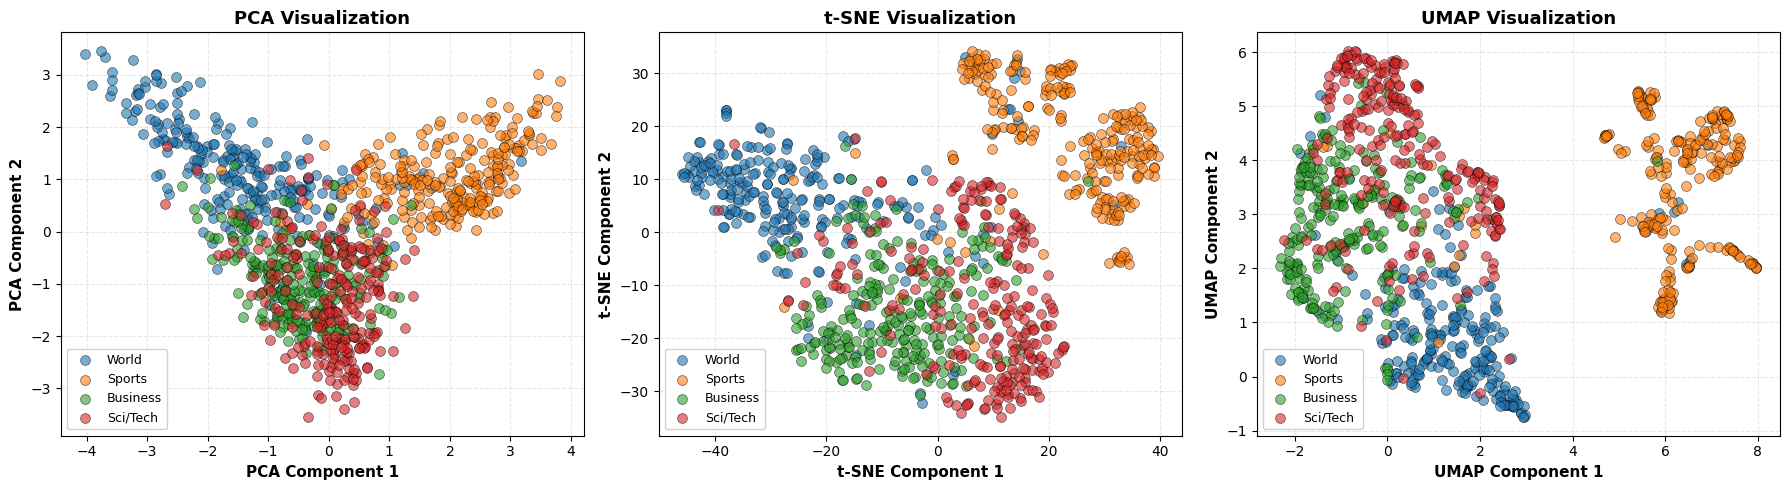

In [2]:
# 4. Visualize all three methods side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
titles = ["PCA", "t-SNE", "UMAP"]
embeddings = [X_pca, X_tsne, X_umap]

for ax, title, X_embedded in zip(axes, titles, embeddings, strict=True):
    for i, (name, color) in enumerate(zip(target_names, colors, strict=True)):
        mask = y == i
        ax.scatter(
            X_embedded[mask, 0],
            X_embedded[mask, 1],
            c=color,
            label=name,
            alpha=0.6,
            s=50,
            edgecolors="k",
            linewidth=0.5,
        )

    ax.set_xlabel(f"{title} Component 1", fontsize=11, fontweight="bold")
    ax.set_ylabel(f"{title} Component 2", fontsize=11, fontweight="bold")
    ax.set_title(f"{title} Visualization", fontsize=13, fontweight="bold")
    ax.legend(loc="best", framealpha=0.9, fontsize=9)
    ax.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()